# Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action = 'ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-ray 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#프로젝트 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 14

# Step 2. 데이터 준비하기

In [2]:
#데이터 열기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [3]:
#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할
#train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#모아진 filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [4]:
#파일 경로의 'NORMAL'이나 'PNEUMONIA'로 정상, 폐렴 이미지 개수 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [5]:
#tf.data 인스턴스를 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


In [6]:
#Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {TRAIN_IMG_COUNT}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validationg images count: {VAL_IMG_COUNT}')


Training images count: 4185
Validationg images count: 1047


In [7]:
#파일 경로의 'NORMAL'이나 'PNEUMONIA'로 라벨 데이터 만드는 함수 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" #폐렴이면 양성(True), 노말이면 음성(False) 

In [8]:
#이미지의 사이즈를 통일 시키고 
#GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여보자

#이미지를 알맞은 형식으로 바꾸자
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3) #이미지를 unit8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) #float32타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) #이미지 사이즈를 IMAGE_SIZE로 수정
    return img

#이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) #라벨 검출
    img = tf.io.read_file(file_path) #이미지 읽기
    img = decode_img(img) #이미지를 알맞은 형식으로 수정
    return img, label

In [9]:
#train 데이터 셋과 validation 데이터 셋을 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [10]:
#이미지가 잘 리사이즈 되었는지, 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [11]:
# test 데이터셋도 만들기, 데이터 개수도 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화

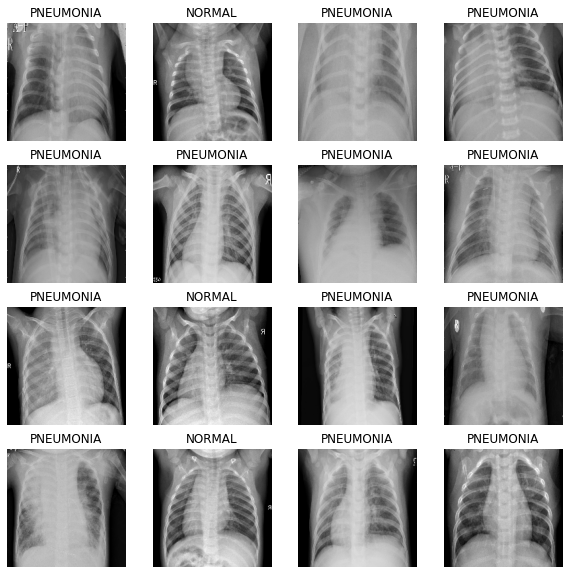

In [13]:
#이미지 배치를 입력하면 여러장의 이미지를 보여준다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE//4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

심장이 왼쪽으로 치우쳐 있는 것이 원래의 데이터 이미지이고, 심장이 오른쪽으로 치우쳐 있는 것이 좌우 반전 된 이미지이다.

# Step 4. CNN 모델링

In [14]:
#Convolution block 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [15]:
#dense block 만들기
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [16]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),

        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리


In [17]:
weight_for_0 = (1/ COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/ COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [18]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = METRICS)
    
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_ds,
    validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
    class_weight = class_weight,
    )    

Epoch 1/14
261/261 [==============================] - 63s 188ms/step - loss: 0.4959 - accuracy: 0.7490 - precision: 0.9210 - recall: 0.7247 - val_loss: 0.6812 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/14
261/261 [==============================] - 49s 189ms/step - loss: 0.2592 - accuracy: 0.9083 - precision: 0.9671 - recall: 0.9076 - val_loss: 1.0422 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/14
261/261 [==============================] - 50s 191ms/step - loss: 0.2160 - accuracy: 0.9219 - precision: 0.9738 - recall: 0.9199 - val_loss: 0.4217 - val_accuracy: 0.8250 - val_precision: 1.0000 - val_recall: 0.7624
Epoch 4/14
261/261 [==============================] - 50s 192ms/step - loss: 0.1967 - accuracy: 0.9306 - precision: 0.9750 - recall: 0.9305 - val_loss: 0.1644 - val_accuracy: 0.9462 - val_precision: 0.9972 - val_recall: 0.9292
Epoch 5/14
261/261 [==============================] - 52s 199ms/step - loss: 0.1704 - accura

# Step 7. 결과 확인과 시각화

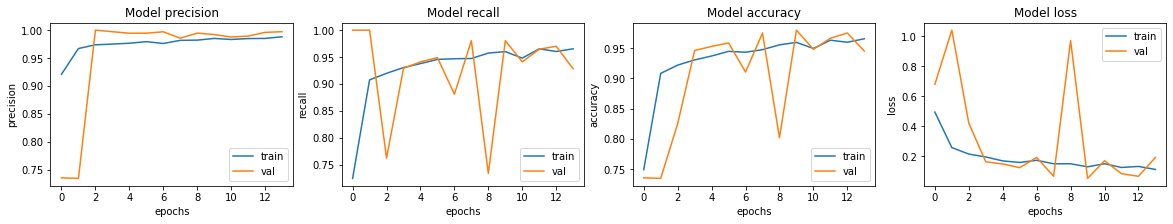

In [19]:
fig, ax = plt.subplots(1, 4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [20]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss}, \nAccuracy: {accuracy}, \nPrecision: {precision}, \nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.5906 - accuracy: 0.8638 - precision: 0.8381 - recall: 0.9692
Loss: 0.5905691981315613, 
Accuracy: 0.8637820482254028, 
Precision: 0.8381374478340149, 
Recall: 0.9692307710647583




모델을 몇 번 돌리면서 에포크를 보고 적당한 에포크를 찾아 돌렸더니 정확도가 85퍼센트가 넘게 나왔다. 
하지만 똑같은 세팅으로 여러번 돌려봤는데 70프로대가 나올 때도 있었어서 모델을 돌릴 때마다 일정한 정확도가 나오지 않는다는 것을 알게 됐다.

유방암 데이터를 다뤘을 때처럼, 질병에 관련된 데이터에서는 recall 값 또한 중요한데, 0.9692로 꽤 높게 나온 것을 알 수 있다.

에포크를 30으로 높여서 해보니 60퍼센트 대로 정확도가 너무 낮게 나왔었는데, 아마 오버피팅이 되어 그런 것 같다.
 
배치사이즈를 16, 8, 4로 반씩 줄여가며 해봤었는데 
줄일 수록 정확도가 대체적으로 낮게 나왔다.

